In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
os.chdir('../')

In [3]:
# Define base parameters
emb_p = '/home/xlv0877/proj_home/dl/resources/genePT_embeddings/GenePT_gene_embedding_ada_text.pickle'
emb_p = '/home/xlv0877/proj_home/dl/resources/genePT_embeddings/GenePT_gene_protein_embedding_model_3_text.pickle'
#adata_p = '/home/xlv0877/proj_home/dl/data/test/1000/mixscale/mixscale_filtered.h5ad'
adata_p = '/home/xlv0877/proj_home/dl/data/studies/iPSC_KOFL_Mali/PaperPerturbations.h5ad'

In [4]:
# Extract information on target gene perturbations
import scanpy as sc

adata = sc.read(adata_p)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [5]:
# Add mixscale scores
obs = '/home/xlv0877/proj_home/dl/data/studies/iPSC_KOFL_Mali/PaperPerturbations_mixscale_obs.csv'
obs = pd.read_csv(obs, index_col=0)
adata.obs.set_index('cell_barcode', inplace=True)
adata = adata[obs['cell_barcode']].copy()
adata.obs['mixscale_score'] = obs['mixscale_score'].values

In [6]:
import pickle

# Load data
with open(emb_p, 'rb') as file:
    emb = pickle.load(file)

In [7]:
# Isolate gene targets
gene_targets = adata.obs.perturbation.unique()
# Filter for genes that are available in embedding
available_targets = set(gene_targets).intersection(set(emb.keys()))
print(f'Found {len(available_targets)}/{len(gene_targets)} perturbations in resource')

Found 33/34 perturbations in resource


In [8]:
# Filter embedding for available genes
t_emb = {k:v for k,v in emb.items() if k in available_targets}
# Convert to dataframe
t_emb = pd.DataFrame(t_emb).T
# Add control and unknown label to embedding
ctrl_row = np.zeros((1, t_emb.shape[1]))
unknown_row = np.zeros((1, t_emb.shape[1]))
zero_rows = pd.DataFrame(np.concatenate([ctrl_row, unknown_row], axis=0), index=['control', 'unknown'])
t_emb = pd.concat([t_emb, zero_rows], axis=0)

In [9]:
# Create a map of embedding index and gene
gene_emb_idx_map = pd.DataFrame(t_emb.index.factorize()).T
gene_emb_idx_map.columns = ['emb_idx', 'gene']

In [10]:
# Merge adata.obs with embedding map
adata_to_emb_idx = (
    adata.obs[['perturbation']]
    .reset_index(names='cell_idx')
    .merge(gene_emb_idx_map, left_on='perturbation', right_on='gene', how='left')
)
# Set perturbations that are not found to unknown, which is the last row in the map
adata_to_emb_idx.emb_idx.fillna(gene_emb_idx_map.index[-1], inplace=True)

In [11]:
# Add cell-specific gene embedding to .obsm for model to use
adata.obsm['gene_embedding'] = np.array(t_emb)[adata_to_emb_idx.emb_idx.astype(int)]

In [12]:
# Multiply by mixscsale score
adata.obsm['gene_embedding'] *= np.array(adata.obs['mixscale_score'])[:,np.newaxis]

In [13]:
# Convert to sparse matrix for training
import scipy.sparse as sp
adata.obsm['gene_embedding'] = sp.csr_matrix(adata.obsm['gene_embedding'])

In [15]:
adata.obsm['gene_embedding']

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 35573760 stored elements and shape (21580, 3072)>

In [94]:
# Save adata
adata_o = os.path.join(os.path.dirname(adata_p), 'PaperPerturbations_w_emb.h5ad')
adata.write_h5ad(adata_o)

### Prepare training data

In [219]:
test = adata[adata.obs.perturbation.isin(adata.obs.perturbation.value_counts()[:10].index)].copy()
sc.pp.log1p(test)
sc.pp.scale(test)

In [220]:
# Define labels
ctrl_key = 'control'
cls_labels = np.array(['celltype', 'perturbation_type', 'perturbation'])

In [221]:
# Add control label
test.obs['is_ctrl'] = False
test.obs.loc[test.obs[cls_labels[-1]]==ctrl_key, 'is_ctrl'] = True

In [227]:
p_pos = -1
cls_range = np.arange(len(cls_labels))
mask = cls_range != cls_range[p_pos]
cls_labels_excl = np.array(cls_labels)[mask].tolist()

In [229]:
cls_labels_excl

['celltype', 'perturbation_type']

In [230]:
cpp = test.obs.groupby(cls_labels_excl, observed=True)['is_ctrl'].value_counts()

In [231]:
cpp

celltype                          perturbation_type  is_ctrl
lymphoblasts                      CRISPRi            True       83608
                                                     False       5278
retinal pigment epithelial cells  CRISPRi            True       11288
                                                     False       7929
Name: count, dtype: int64

In [232]:
# Get
idc = []
ctrl_idc = []
for group, data in test.obs[~test.obs.is_ctrl].groupby(cls_labels_excl, observed=True):
    mask = True
    idc.extend(data.index)
    print(group)
    for i, g in enumerate(group):
        mask &= test.obs[cls_labels[i]]==g
    print(np.sum(mask), 'total', n_p, 'group')
    n_p = cpp[*group, False]
    ctrl_idc.extend(test.obs[mask].sample(n_p).index)

('lymphoblasts', 'CRISPRi')
88886 total 7929 group
('retinal pigment epithelial cells', 'CRISPRi')
19217 total 5278 group


In [233]:
# Filter for perturbed cells and ensure correct order by groups
ctrl_layer = test[ctrl_idc].X

In [234]:
# Filter cells
test = test[idc].copy()
test.layers['B'] = ctrl_layer

In [92]:
# Check if we have enough control cells to draw every perturbation
n_ctrl_cells = cpp['control']
n_pert_cells = cpp[cpp.index!='control'].sum()
replace = n_ctrl_cells < n_pert_cells

In [99]:
# Randomly draw number of perturbed cells from control cells
x_b_cells = test.obs.sample(n_pert_cells, replace=replace).index

In [101]:
test[x_b_cells]

View of AnnData object with n_obs × n_vars = 13207 × 7079
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'perturbation', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'dataset', 'perturbation_type', 'exact_perturbation', 'is_ctrl', 'mixscale_score', 'NP', 'mixscale_mask'
    obsm: 'X_pca', 'gene_embedding'

In [26]:
# Simulate expression encoder with pca
sc.pp.pca(test, n_comps=10)

In [28]:
# Simulate embedding encoder with pca
test.obsm['g'] = sc.pp.pca(test.obsm['gene_embedding'], n_comps=10)

In [30]:
tensors = test.obsm

2025-04-17 10:45:04.973725: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 10:45:06.271073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


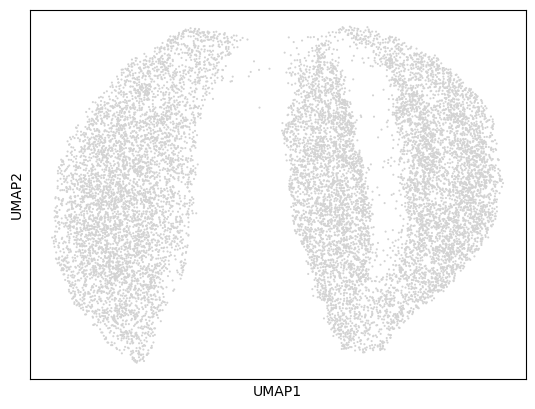

In [33]:
# Plot X latent
sc.pp.neighbors(test, use_rep='X_pca')
sc.tl.umap(test)
sc.pl.umap(test, color='perturbation')

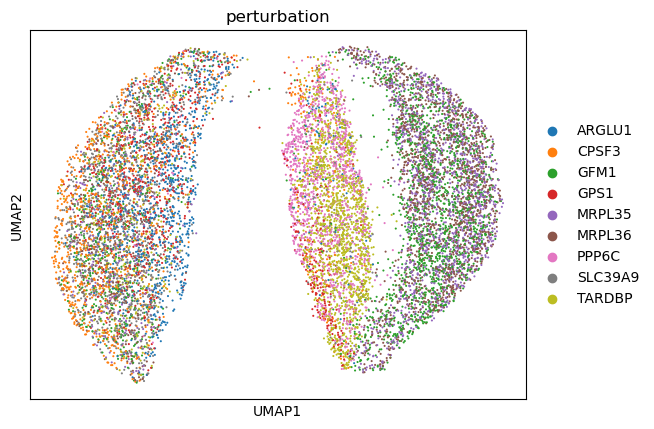

In [34]:
sc.pl.umap(test, color='perturbation')

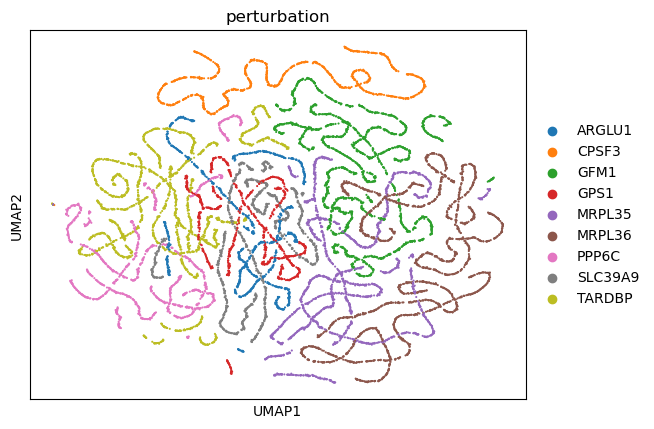

In [35]:
# Plot latent g
sc.pp.neighbors(test, use_rep='g')
sc.tl.umap(test)
sc.pl.umap(test, color='perturbation')

In [54]:
from scipy.stats import spearmanr

In [72]:
spc = spearmanr(test.obsm['g'], axis=0)

<Axes: >

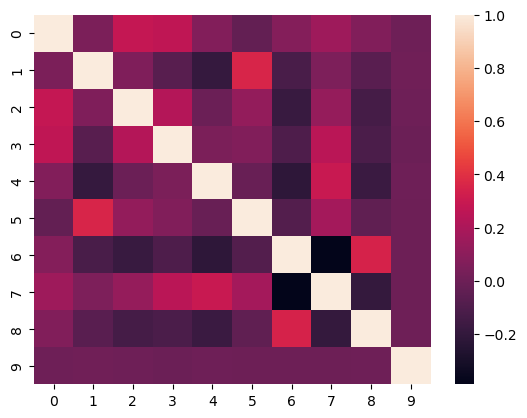

In [73]:
import seaborn as sns
sns.heatmap(spc.statistic)

In [47]:
test_g = sc.get.aggregate(test, by='perturbation', obsm='g', func='mean')
test_g.X = test_g.layers['mean']
test_g.obsm['X_pca'] = test_g.layers['mean']

In [42]:
sc.pp.neighbors(test_g, use_rep='X')

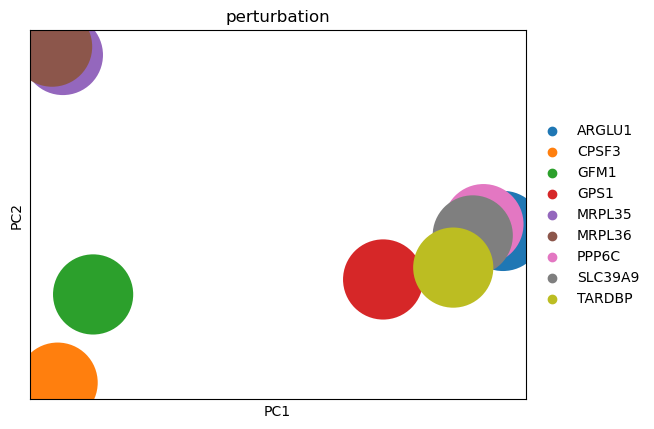

In [48]:
sc.pl.pca(test_g, color='perturbation')

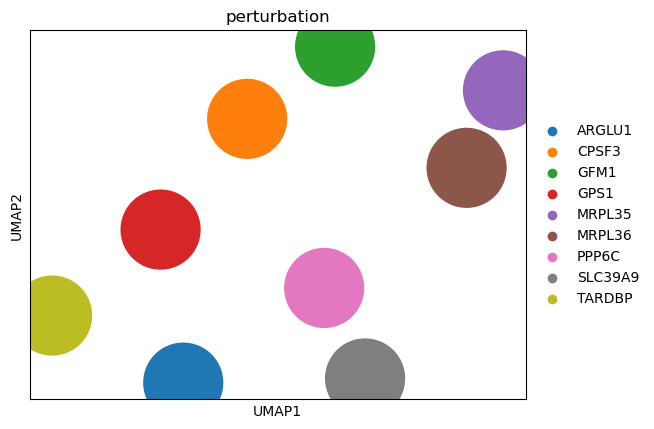

In [45]:
sc.tl.umap(test_g)
sc.pl.umap(test_g, color='perturbation')

### Create random signatures

<Axes: ylabel='Count'>

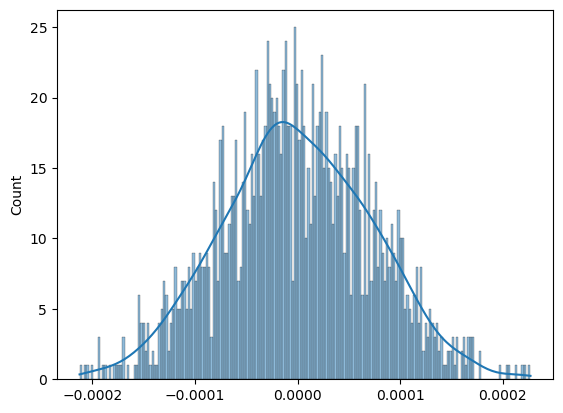

In [91]:
from scipy.stats import laplace

random_noise_embedding = laplace.rvs(loc=0, scale=0.03, size=adata.obsm['gene_embedding'].shape)

sns.histplot(random_noise_embedding.mean(axis=0), bins=200, kde=True)

In [1]:
t_emb

NameError: name 't_emb' is not defined

<Axes: ylabel='Count'>

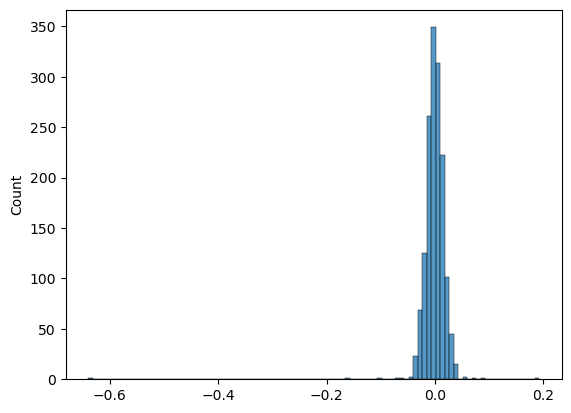

In [32]:
sns.histplot(t_emb.mean(axis=0), bins=100)

In [19]:
import anndata as ad

e_adata = ad.AnnData(X=t_emb, obs=pd.DataFrame(t_emb.index, columns=['gene'], index=t_emb.index))

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


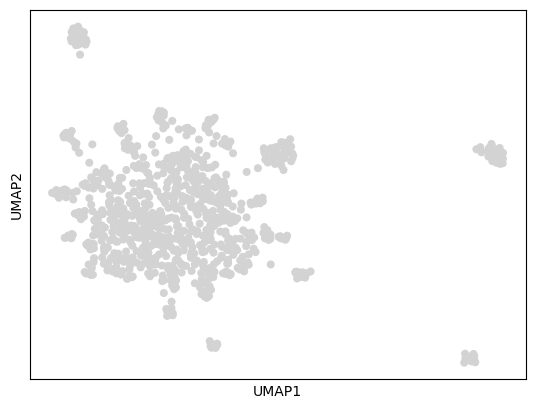

In [29]:
sc.pp.pca(e_adata)
sc.pp.neighbors(e_adata)
sc.tl.umap(e_adata)
sc.pl.umap(e_adata, legend_loc=None)

<Axes: ylabel='Count'>

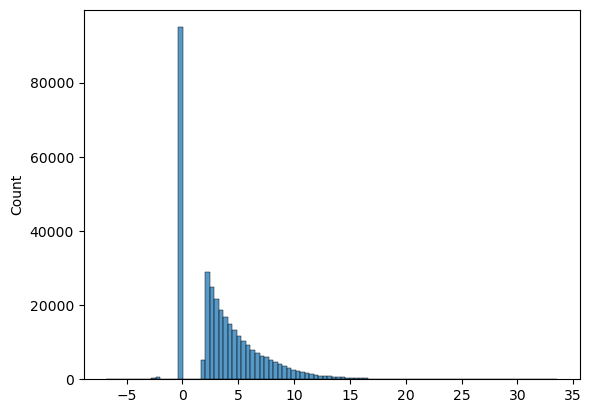

In [80]:
sns.histplot(adata.obs.mixscale_score.ravel(), bins=100)

<Axes: ylabel='Count'>

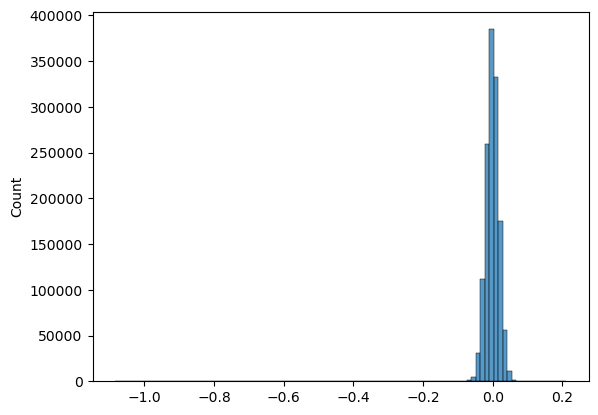

In [92]:
sns.histplot(np.log1p(np.array(t_emb).ravel()), bins=100)